In [55]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
from os.path import join
from IPython.display import clear_output, display

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
from keras.models import load_model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty
import gains as genetic

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
ani_char_to_index = json.loads(f.read())
ani_char_set = set(ani_char_to_index.keys())
ani_char_list = list(ani_char_to_index.keys())
ani_chars_in_dict = len(ani_char_list)
ani_index_to_char = dict((i, c) for i, c in enumerate(ani_char_list))

#training array info
import json
f = open("../data/gdb_char_to_index.json","r")
cat_char_to_index = json.loads(f.read())
cat_char_set = set(cat_char_to_index.keys())
cat_char_list = list(cat_char_to_index.keys())
cat_chars_in_dict = len(cat_char_list)
cat_index_to_char = dict((i, c) for i, c in enumerate(cat_char_list))

char_to_index = ani_char_to_index
char_set = ani_char_set
char_list = ani_char_list
chars_in_dict = ani_chars_in_dict
index_to_char = ani_index_to_char
        
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5')

# Search by Property
The general setup-
1. generate N structures of target Cp and p values from the VAE and GA (and maybe a VAE w/o QSPR --- use a separate QSPR --- this would be to show that the organization of the latent space is actually helping…)
2. calculate ground-truth values using QM/MD
3. compare the % of the found structures that were close to the target for each method.

So the table is:

- **properties**: p, Cp
- **models**: VAE, VAE+QSPR, EA
- **number of**: total function calls, returned structures rdkit-sanitizable, returned gaussian structures, returned MD systems, % error of prediction

The basic setup is here. we will want to, however, throw out structures where the Cp/p was far from our top 10 structure seeds (high Cp, low p)

We seed all methods with the top 10 structures from our dataset. 

# No QSPR

In [56]:
hits = 100

In [57]:
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5')

In [58]:
model_ID = ['cpt']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [59]:
df_cpt_no_qspr = generate_solvent_vae(gen3vae, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=['cpt_4'],
                                      verbose=1)

ani seed                   CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
attempts                                                     14530
candidate                             CCCCCCCCCCCCCC[N+](CC)(CC)OC
cat seed                              CCCCCCCCCCCCCC[N+](CC)(CC)CC
rdkit qspr                                                 1551.17
rdkit-md qspr                                              1761.01
salt             CCCCCCCCCCCCCC[N+](CC)(CC)OC.CC(CC(C)(C)C)CP(=...
temperature                                                1.95934
vae qspr                                                  0.956651
Name: 99, dtype: object
100/100 found


In [60]:
model_ID = ['thermal_conductivity']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	23
unique cations:	10
min/max values:	0.1667, 0.2380

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [61]:
df_thermal_no_qspr = generate_solvent_vae(gen3vae, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=None,
                                      verbose=1)

ani seed                          CC(=O)[O-]
attempts                               39777
candidate                 CCCCn1cc[n+](CC)c1
cat seed                   CCCCn1cc[n+](c1)C
rdkit qspr                              0.17
salt           CCCCn1cc[n+](CC)c1.CC(=O)[O-]
temperature                          1.89365
vae qspr                             1.00482
Name: 99, dtype: object
100/100 found


In [62]:
model_ID = ['viscosity']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Viscosity, Pa&#8226;s
total salts in training data:	3277
unique salts:	18
unique cations:	10
min/max values:	0.0017, 0.0106

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [63]:
df_viscosity_no_qspr = generate_solvent_vae(gen3vae, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=None,
                                      verbose=1)

ani seed                       C(=C(C#N)C#N)=[N-]
attempts                                   105234
candidate                         C[N+]1=C(O)C=C1
cat seed                          C[N+]1=C(CCC1)O
rdkit qspr                                   0.01
salt           C[N+]1=C(O)C=C1.C(=C(C#N)C#N)=[N-]
temperature                               1.82799
vae qspr                                 0.917589
Name: 99, dtype: object
100/100 found


In [64]:
model_ID = ['density']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Specific density, kg/m<SUP>3</SUP>
total salts in training data:	5631
unique salts:	17
unique cations:	10
min/max values:	871.3000, 962.7000

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [65]:
df_density_no_qspr = generate_solvent_vae(gen3vae, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=['density_4'],
                                      verbose=1)

ani seed                                 C(CCN)C[C@@H](C(=O)[O-])N
attempts                                                      5807
candidate                        CCCCCCCC[S+](C)(CCCCCCCC)CCCCCCCC
cat seed                         CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC
rdkit qspr                                                  939.24
rdkit-md qspr                                               914.86
salt             CCCCCCCC[S+](C)(CCCCCCCC)CCCCCCCC.C(CCN)C[C@@H...
temperature                                                1.46207
vae qspr                                                   1.03754
Name: 99, dtype: object
100/100 found


# 10 Epoch

In [66]:
gen3vae_viscosity = TwoMoleculeVAE()
gen3vae_viscosity.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_viscosity_10.h5')
gen3vae_thermal = TwoMoleculeVAE()
gen3vae_thermal.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_thermal_conductivity_10.h5')
gen3vae_cpt = TwoMoleculeVAE()
gen3vae_cpt.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_10.h5')
gen3vae_density = TwoMoleculeVAE()
gen3vae_density.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_density_10.h5')

In [67]:
model_ID = ['cpt']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [68]:
df_cpt_10_qspr = generate_solvent_vae(gen3vae_cpt, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=['cpt_4'],
                                      verbose=1)

ani seed                    FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
attempts                                                      8263
candidate                 CCCCCCCCCCCCCCCCCCCCC[P+](C)(CCCC)CCCCCC
cat seed                C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC
rdkit qspr                                                 1543.19
rdkit-md qspr                                              1423.64
salt             CCCCCCCCCCCCCCCCCCCCC[P+](C)(CCCC)CCCCCC.FC(F)...
temperature                                                1.70204
vae qspr                                                   1728.04
Name: 99, dtype: object
100/100 found


In [69]:
model_ID = ['thermal_conductivity']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	23
unique cations:	10
min/max values:	0.1667, 0.2380

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [70]:
df_thermal_10_qspr = generate_solvent_vae(gen3vae_thermal, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=None,
                                      verbose=1)

ani seed                             [B-](F)(F)(F)F
attempts                                      94899
candidate                     CC#CCCCCn1cc[n+](C)c1
cat seed                      CCCCCCCCn1cc[n+](c1)C
rdkit qspr                                     0.18
salt           CC#CCCCCn1cc[n+](C)c1.[B-](F)(F)(F)F
temperature                                 1.49949
vae qspr                                   0.140391
Name: 99, dtype: object
100/100 found


In [71]:
model_ID = ['viscosity']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Viscosity, Pa&#8226;s
total salts in training data:	3277
unique salts:	18
unique cations:	10
min/max values:	0.0017, 0.0106

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [72]:
df_viscosity_10_qspr = generate_solvent_vae(gen3vae_viscosity, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=None,
                                      verbose=1)

ani seed                  C(#N)[N-]C#N
attempts                         70200
candidate                   C[N+2](C)C
cat seed                    C[NH+](C)C
rdkit qspr                        0.01
salt           C[N+2](C)C.C(#N)[N-]C#N
temperature                    1.84113
vae qspr                   0.000769966
Name: 99, dtype: object
100/100 found


In [73]:
model_ID = ['density']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Specific density, kg/m<SUP>3</SUP>
total salts in training data:	5631
unique salts:	17
unique cations:	10
min/max values:	871.3000, 962.7000

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [74]:
df_density_10_qspr = generate_solvent_vae(gen3vae_density, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=['density_4'],
                                      verbose=1)

ani seed                                  CCCCCCCCCC(=O)[O-]
attempts                                                3097
candidate                           CC=C[N+](CCCC)CCCC=CCCCC
cat seed                            CCCC[P+](CCCC)(CCCC)CCCC
rdkit qspr                                            833.15
rdkit-md qspr                                         864.34
salt             CC=C[N+](CCCC)CCCC=CCCCC.CCCCCCCCCC(=O)[O-]
temperature                                         0.449574
vae qspr                                             998.295
Name: 99, dtype: object
100/100 found


# 30 Epoch

In [75]:
gen3vae_viscosity = TwoMoleculeVAE()
gen3vae_viscosity.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_viscosity_30.h5')
gen3vae_thermal = TwoMoleculeVAE()
gen3vae_thermal.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_thermal_conductivity_30.h5')
gen3vae_cpt = TwoMoleculeVAE()
gen3vae_cpt.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_30.h5')
gen3vae_density = TwoMoleculeVAE()
gen3vae_density.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_density_30.h5')

In [76]:
model_ID = ['cpt']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [77]:
df_cpt_30_qspr = generate_solvent_vae(gen3vae_cpt, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=['cpt_4'],
                                      verbose=1)

ani seed                   CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
attempts                                                     13996
candidate                                              CCCCCCCCCPC
cat seed                              CCCCCCCCCCCCCC[N+](CC)(CC)CC
rdkit qspr                                                 1676.89
rdkit-md qspr                                              1387.62
salt             CCCCCCCCCPC.CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C...
temperature                                                1.59659
vae qspr                                                   1033.46
Name: 99, dtype: object
100/100 found


In [78]:
model_ID = ['thermal_conductivity']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	23
unique cations:	10
min/max values:	0.1667, 0.2380

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [79]:
df_thermal_30_qspr = generate_solvent_vae(gen3vae_thermal, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=None,
                                      verbose=1)

ani seed                     N#C[B-](C#N)(C#N)C#N
attempts                                    54614
candidate                           CN1C=C[N+]=C1
cat seed                           Cn1cc[n+](c1)C
rdkit qspr                                   0.18
salt           CN1C=C[N+]=C1.N#C[B-](C#N)(C#N)C#N
temperature                               1.30467
vae qspr                                 0.197407
Name: 99, dtype: object
100/100 found


In [80]:
model_ID = ['viscosity']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Viscosity, Pa&#8226;s
total salts in training data:	3277
unique salts:	18
unique cations:	10
min/max values:	0.0017, 0.0106

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [81]:
df_viscosity_30_qspr = generate_solvent_vae(gen3vae_viscosity, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=None,
                                      verbose=1)

ani seed                       CCC(=O)[O-]
attempts                             13050
candidate                  C[N+]1=C(O)CCN1
cat seed                   C[N+]1=C(CCC1)O
rdkit qspr                            0.01
salt           C[N+]1=C(O)CCN1.CCC(=O)[O-]
temperature                        1.44039
vae qspr                        0.00144712
Name: 99, dtype: object
100/100 found


In [82]:
model_ID = ['density']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Specific density, kg/m<SUP>3</SUP>
total salts in training data:	5631
unique salts:	17
unique cations:	10
min/max values:	871.3000, 962.7000

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [83]:
df_density_30_qspr = generate_solvent_vae(gen3vae_density, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=['density_4'],
                                      verbose=1)

ani seed                                      N#C[B-](C#N)(C#N)C#N
attempts                                                      8763
candidate                             CCCCCCCC[P+](CCCC)(CCCC)CCOC
cat seed                          [P+](CCCC)(CCCC)(CCCC)(CCCCCCCC)
rdkit qspr                                                  913.03
rdkit-md qspr                                               973.47
salt             CCCCCCCC[P+](CCCC)(CCCC)CCOC.N#C[B-](C#N)(C#N)C#N
temperature                                                1.74777
vae qspr                                                   716.052
Name: 99, dtype: object
100/100 found


# 100 Epoch

In [84]:
gen3vae_viscosity = TwoMoleculeVAE()
gen3vae_viscosity.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_viscosity_100.h5')
gen3vae_thermal = TwoMoleculeVAE()
gen3vae_thermal.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_thermal_conductivity_100.h5')
gen3vae_cpt = TwoMoleculeVAE()
gen3vae_cpt.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_100.h5')
gen3vae_density = TwoMoleculeVAE()
gen3vae_density.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_density_100.h5')

In [85]:
model_ID = ['cpt']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [86]:
df_cpt_100_qspr = generate_solvent_vae(gen3vae_cpt, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=['cpt_4'],
                                      verbose=1)

ani seed                                 C(CCN)C[C@@H](C(=O)[O-])N
attempts                                                      7691
candidate                                CCCCC[P+](CCCC)(CCCC)CCCC
cat seed                                  CCCC[P+](CCCC)(CCCC)CCCC
rdkit qspr                                                  982.83
rdkit-md qspr                                               925.41
salt             CCCCC[P+](CCCC)(CCCC)CCCC.C(CCN)C[C@@H](C(=O)[...
temperature                                                1.54245
vae qspr                                                   783.694
Name: 99, dtype: object
100/100 found


In [87]:
model_ID = ['thermal_conductivity']
salts, cations, target = return_top_cations(model_ID, return_min_values=True)

Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	23
unique cations:	10
min/max values:	0.1667, 0.2380

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


In [88]:
df_thermal_100_qspr = generate_solvent_vae(gen3vae_thermal, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=True,
                                      md_model=None,
                                      verbose=1)

ani seed                        [B-](F)(F)(F)F
attempts                                 24065
candidate                     CCC[n+]1ccn(C)c1
cat seed               Cn1cc[n+](c1)CCCCCCCCCC
rdkit qspr                                0.18
salt           CCC[n+]1ccn(C)c1.[B-](F)(F)(F)F
temperature                            1.91736
vae qspr                              0.183526
Name: 99, dtype: object
100/100 found


In [89]:
model_ID = ['viscosity']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Viscosity, Pa&#8226;s
total salts in training data:	3277
unique salts:	18
unique cations:	10
min/max values:	0.0017, 0.0106

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [90]:
df_viscosity_100_qspr = generate_solvent_vae(gen3vae_viscosity, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=None,
                                      verbose=1)

ani seed               CCC(=O)[O-]
attempts                     20632
candidate                  C[NH+]C
cat seed                C[NH+](C)C
rdkit qspr                    0.01
salt           C[NH+]C.CCC(=O)[O-]
temperature                1.39906
vae qspr                0.00718444
Name: 99, dtype: object
100/100 found


In [91]:
model_ID = ['density']
salts, cations, target = return_top_cations(model_ID, return_min_values=False)

Specific density, kg/m<SUP>3</SUP>
total salts in training data:	5631
unique salts:	17
unique cations:	10
min/max values:	871.3000, 962.7000

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [92]:
df_density_100_qspr = generate_solvent_vae(gen3vae_density, 
                                      char_to_index,
                                      smile_max_length=62,
                                      salts=salts,
                                      model_ID=model_ID, 
                                      target=target, 
                                      qspr=True, 
                                      find=hits, 
                                      optimalCutOff=target, 
                                      greaterThanCutOff=False,
                                      md_model=['density_4'],
                                      verbose=1)

ani seed                   CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
attempts                                                      2477
candidate                                         CCCC[N+]1(C)CCC1
cat seed                                    C[N+]1(CCCCC1)CCCCCCCC
rdkit qspr                                                   912.7
rdkit-md qspr                                               913.36
salt             CCCC[N+]1(C)CCC1.CC(CC(C)(C)C)CP(=O)(CC(C)CC(C...
temperature                                               0.751207
vae qspr                                                   1344.62
Name: 99, dtype: object
100/100 found


# view results

In [258]:
props = [cpt, density, viscosity, thermal]
names = ['heat capacity', 'density', 'viscosity', 'thermal conductivity']
epochs = ['no qspr', '10 epoch', '30 epoch', '100 epoch']

In [259]:
cpt = pd.concat([df_cpt_no_qspr, df_cpt_10_qspr, df_cpt_30_qspr, df_cpt_100_qspr], keys=epochs, names=['epochs'])
density = pd.concat([df_density_no_qspr, df_density_10_qspr, df_density_30_qspr, df_density_100_qspr], keys=epochs, names=['epochs'])
viscosity = pd.concat([df_viscosity_no_qspr, df_viscosity_10_qspr, df_viscosity_30_qspr, df_viscosity_100_qspr], keys=epochs, names=['epochs'])
thermal = pd.concat([df_thermal_no_qspr, df_thermal_10_qspr, df_thermal_30_qspr, df_thermal_100_qspr], keys=epochs, names=['epochs'])

In [260]:
df = pd.concat(props, keys=names, names=['prop'])

In [261]:
df.to_csv('../data/property_search_results', index=True)

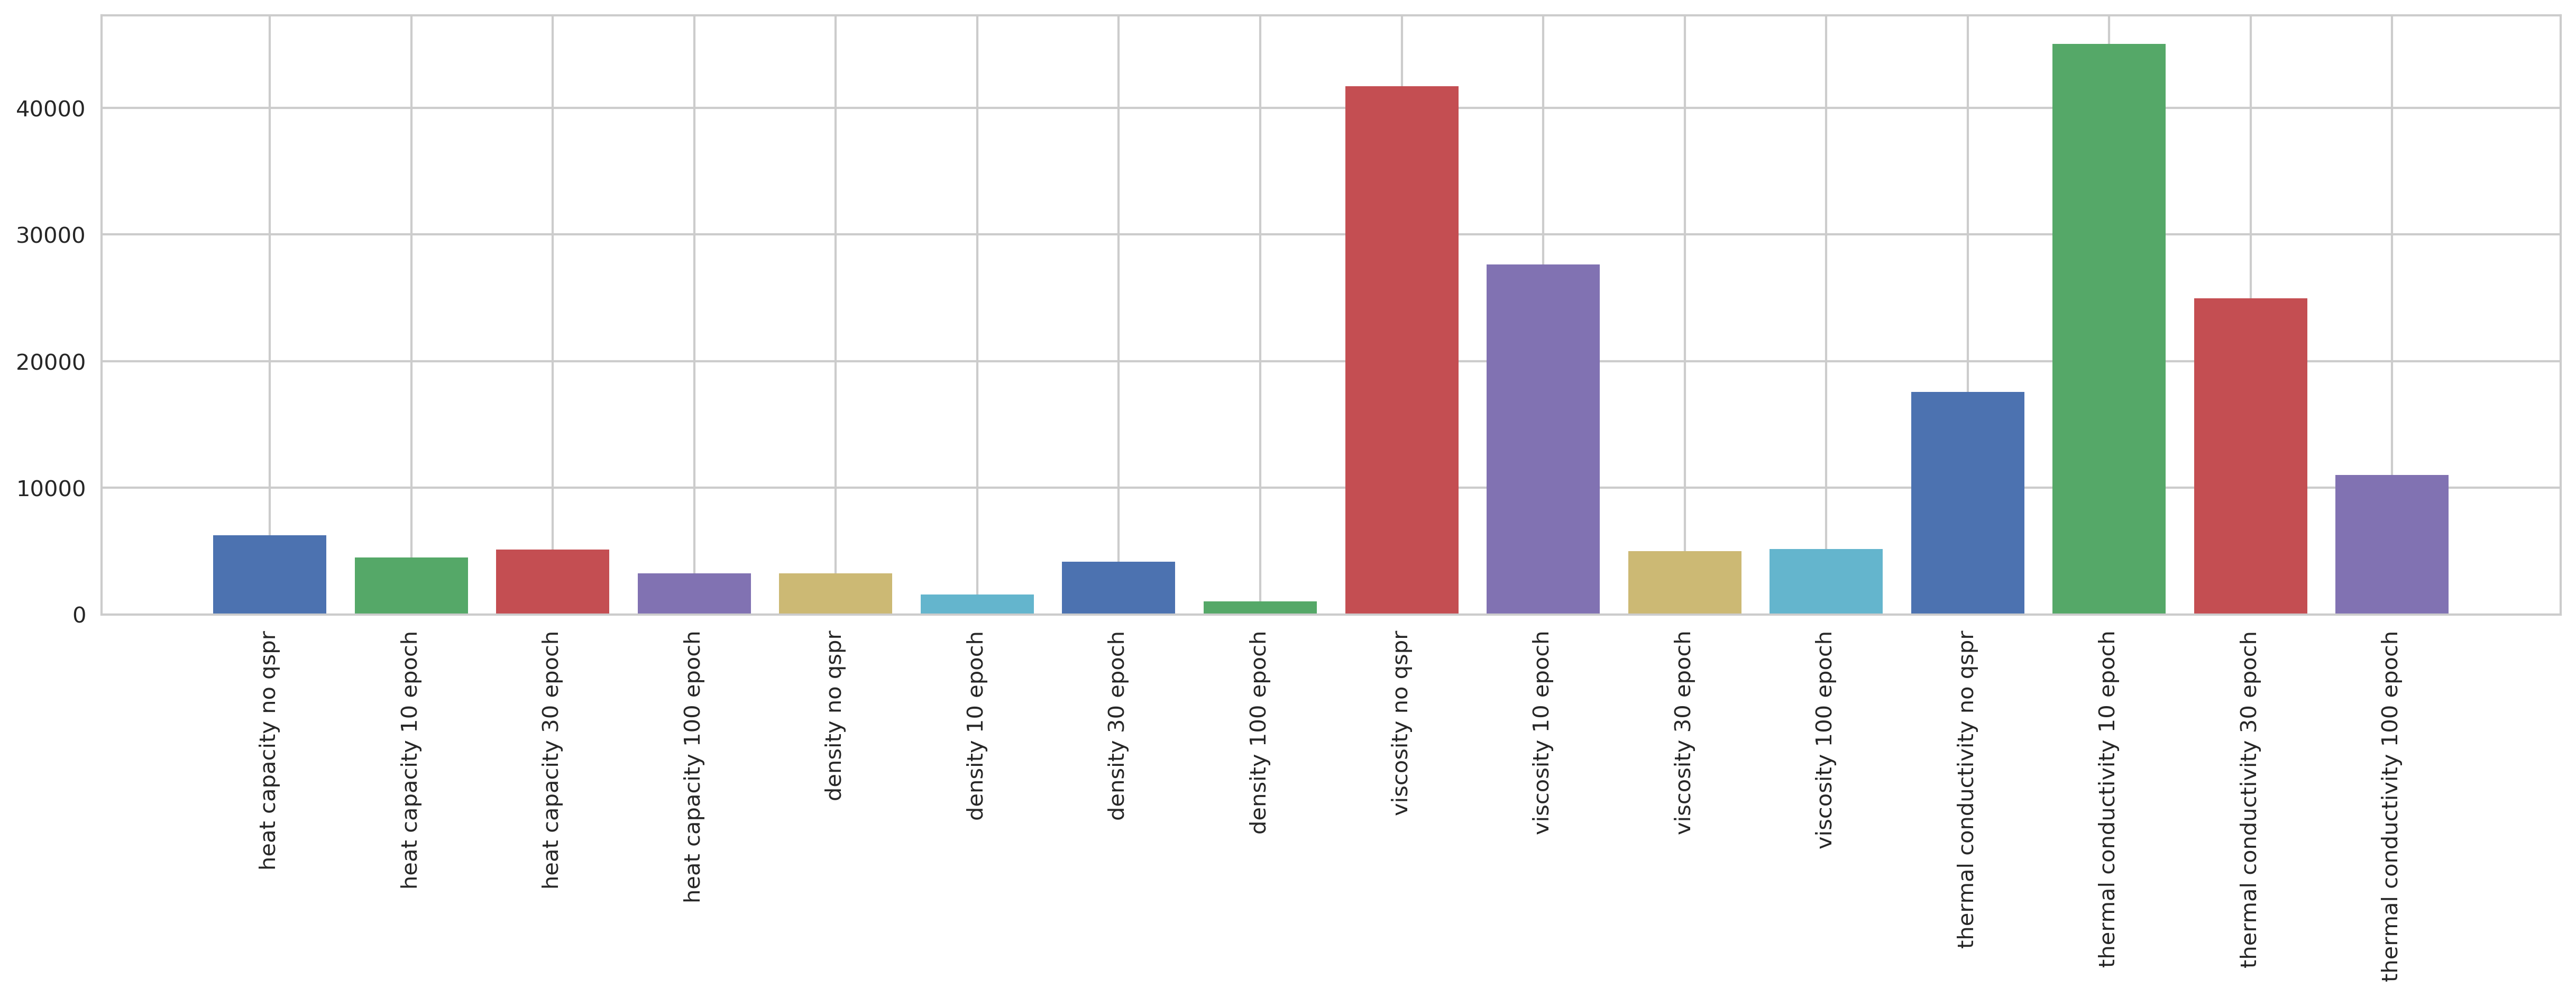

In [265]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1,1, figsize=(20,5), dpi=300)
    for name in names:
        for epoch in epochs:
            ax.bar([name+' '+epoch],df.loc[name].loc[epoch]['attempts'].iloc[50])
    plt.xticks(rotation=90)

In [192]:
pd.read_csv('../data/property_search_results').columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'ani seed', 'attempts',
       'candidate', 'cat seed', 'rdkit qspr', 'rdkit-md qspr', 'salt',
       'temperature', 'vae qspr'],
      dtype='object')

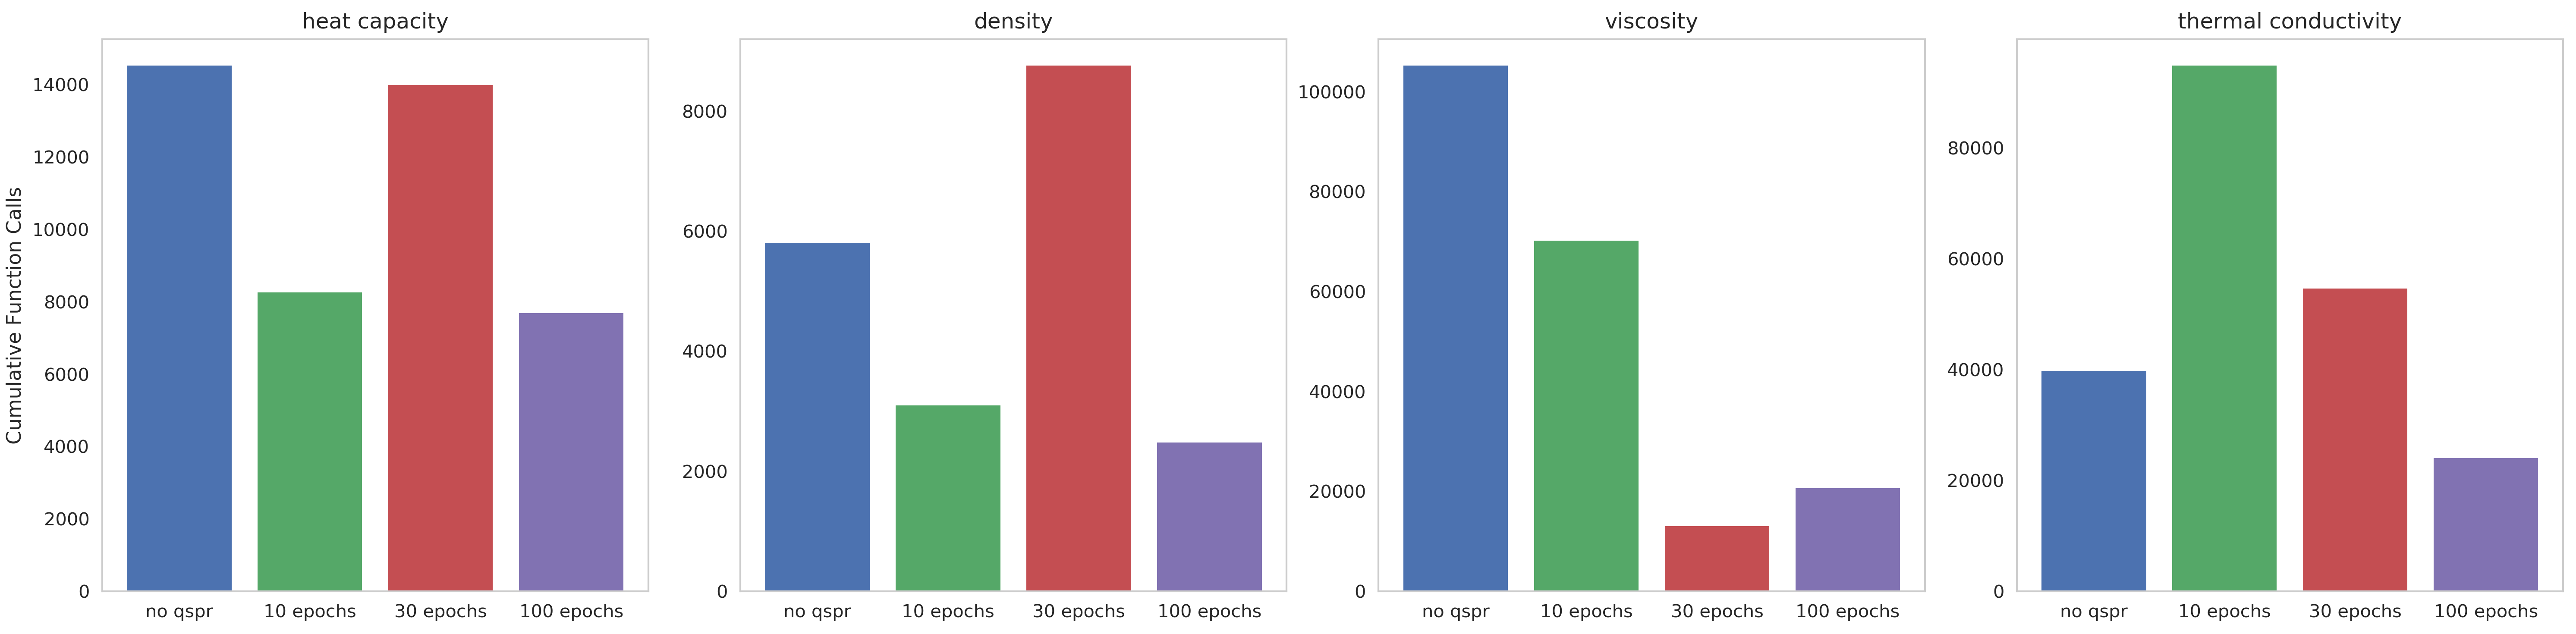

In [266]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1,4, figsize=(20,5), dpi=300, sharey=False)
    for index, df in enumerate(props):
        ax[index].bar(['no qspr'], df.loc['no qspr']['attempts'], label='no qspr')
        ax[index].bar(['10 epochs'], df.loc['10 epoch']['attempts'], label='10 epochs')
        ax[index].bar(['30 epochs'], df.loc['30 epoch']['attempts'], label='30 epochs')
        ax[index].bar(['100 epochs'], df.loc['100 epoch']['attempts'], label='100 epochs')
        ax[index].set_title('{}'.format(names[index]))
        ax[index].grid()
        if index == 0:
            ax[index].set_ylabel('Cumulative Function Calls')
        
    plt.tight_layout()
#     plt.xticks(rotation=90)

In [93]:
# df_viscosity_no_qspr.to_csv('../data/df_gen3vae_viscosity_no_qspr_91102_function_calls', index=False)